# Advanced Regression Assignment - Housing Price Analysis & Prediction

Building an advanced regression model for prediction of housing prices.



#### AIM:

Prediction & analysis of **housing prices** in Australian market.

Specifically, using the given dataset, identify:

    1. Which variables are significant in predicting the price of a house.
    2. How well those variables describe the price of a house.


Following actions are performed as part of the activity:

    1. Data understanding, preparation & EDA
    2. Model building & evaluation
    3. Determining the optimal value of lambda for ridge and lasso regression
    3. Model interpretation

In [571]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


### 1. Data Understanding & Cleaning

Understanding dataset with the help of data dictionary / description

In [572]:
#Look at the dataset 
housing = pd.read_csv('train.csv')

housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [573]:
#Checking the dataset summary

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [574]:
#There are 81 columns in total. Check if there are any columns with full zeros / NaN values
cnt =0
for column in housing:
    if (housing[column].isnull().all() | housing[column].isna().all()):
        print(housing[column])
    else:
        cnt+=1

print('Non zero/NaN columns count :',cnt)

Non zero/NaN columns count : 81


In [575]:
#Identify the columns with 50% or more null values. This step can be done prior to understanding the data as this will not be useful in any analysis
null_pct = (housing.isnull().sum() / len(housing.index))*100
n_pct = pd.DataFrame({'column':null_pct.index, 'pct':null_pct.values})

n_pct = n_pct[n_pct['pct'].apply(lambda x: x>=50.0)]

n_pct.head(10)


,column,pct
6,Alley,93.767123
72,PoolQC,99.520548
73,Fence,80.753425
74,MiscFeature,96.301370


In [576]:
housing.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [577]:
#Drop columns where more than 50% values are nulls

housing = housing.drop(n_pct['column'],axis=1)

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [578]:
#Check for remaining columns having null values
null_pct = (housing.isnull().sum() / len(housing.index))*100
n_pct = pd.DataFrame({'column':null_pct.index, 'pct':null_pct.values})

n_pct = n_pct[n_pct['pct'].apply(lambda x: x>0.0)]

n_pct.head(30) 


,column,pct
3,LotFrontage,17.739726
24,MasVnrType,0.547945
25,MasVnrArea,0.547945
29,BsmtQual,2.534247
30,BsmtCond,2.534247
31,BsmtExposure,2.602740
32,BsmtFinType1,2.534247
34,BsmtFinType2,2.602740
41,Electrical,0.068493
56,FireplaceQu,47.260274


#### There are 15 more columns with atleast one null value. 
We will decide what to do with these columns after understanding the dataset from Regression analysis perspective.


In [579]:
# MiscVal - $Value of miscellaneous feature
#This can be dropped as we alread dropped the MiscFeature column

housing = housing.drop('MiscVal', axis=1)

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

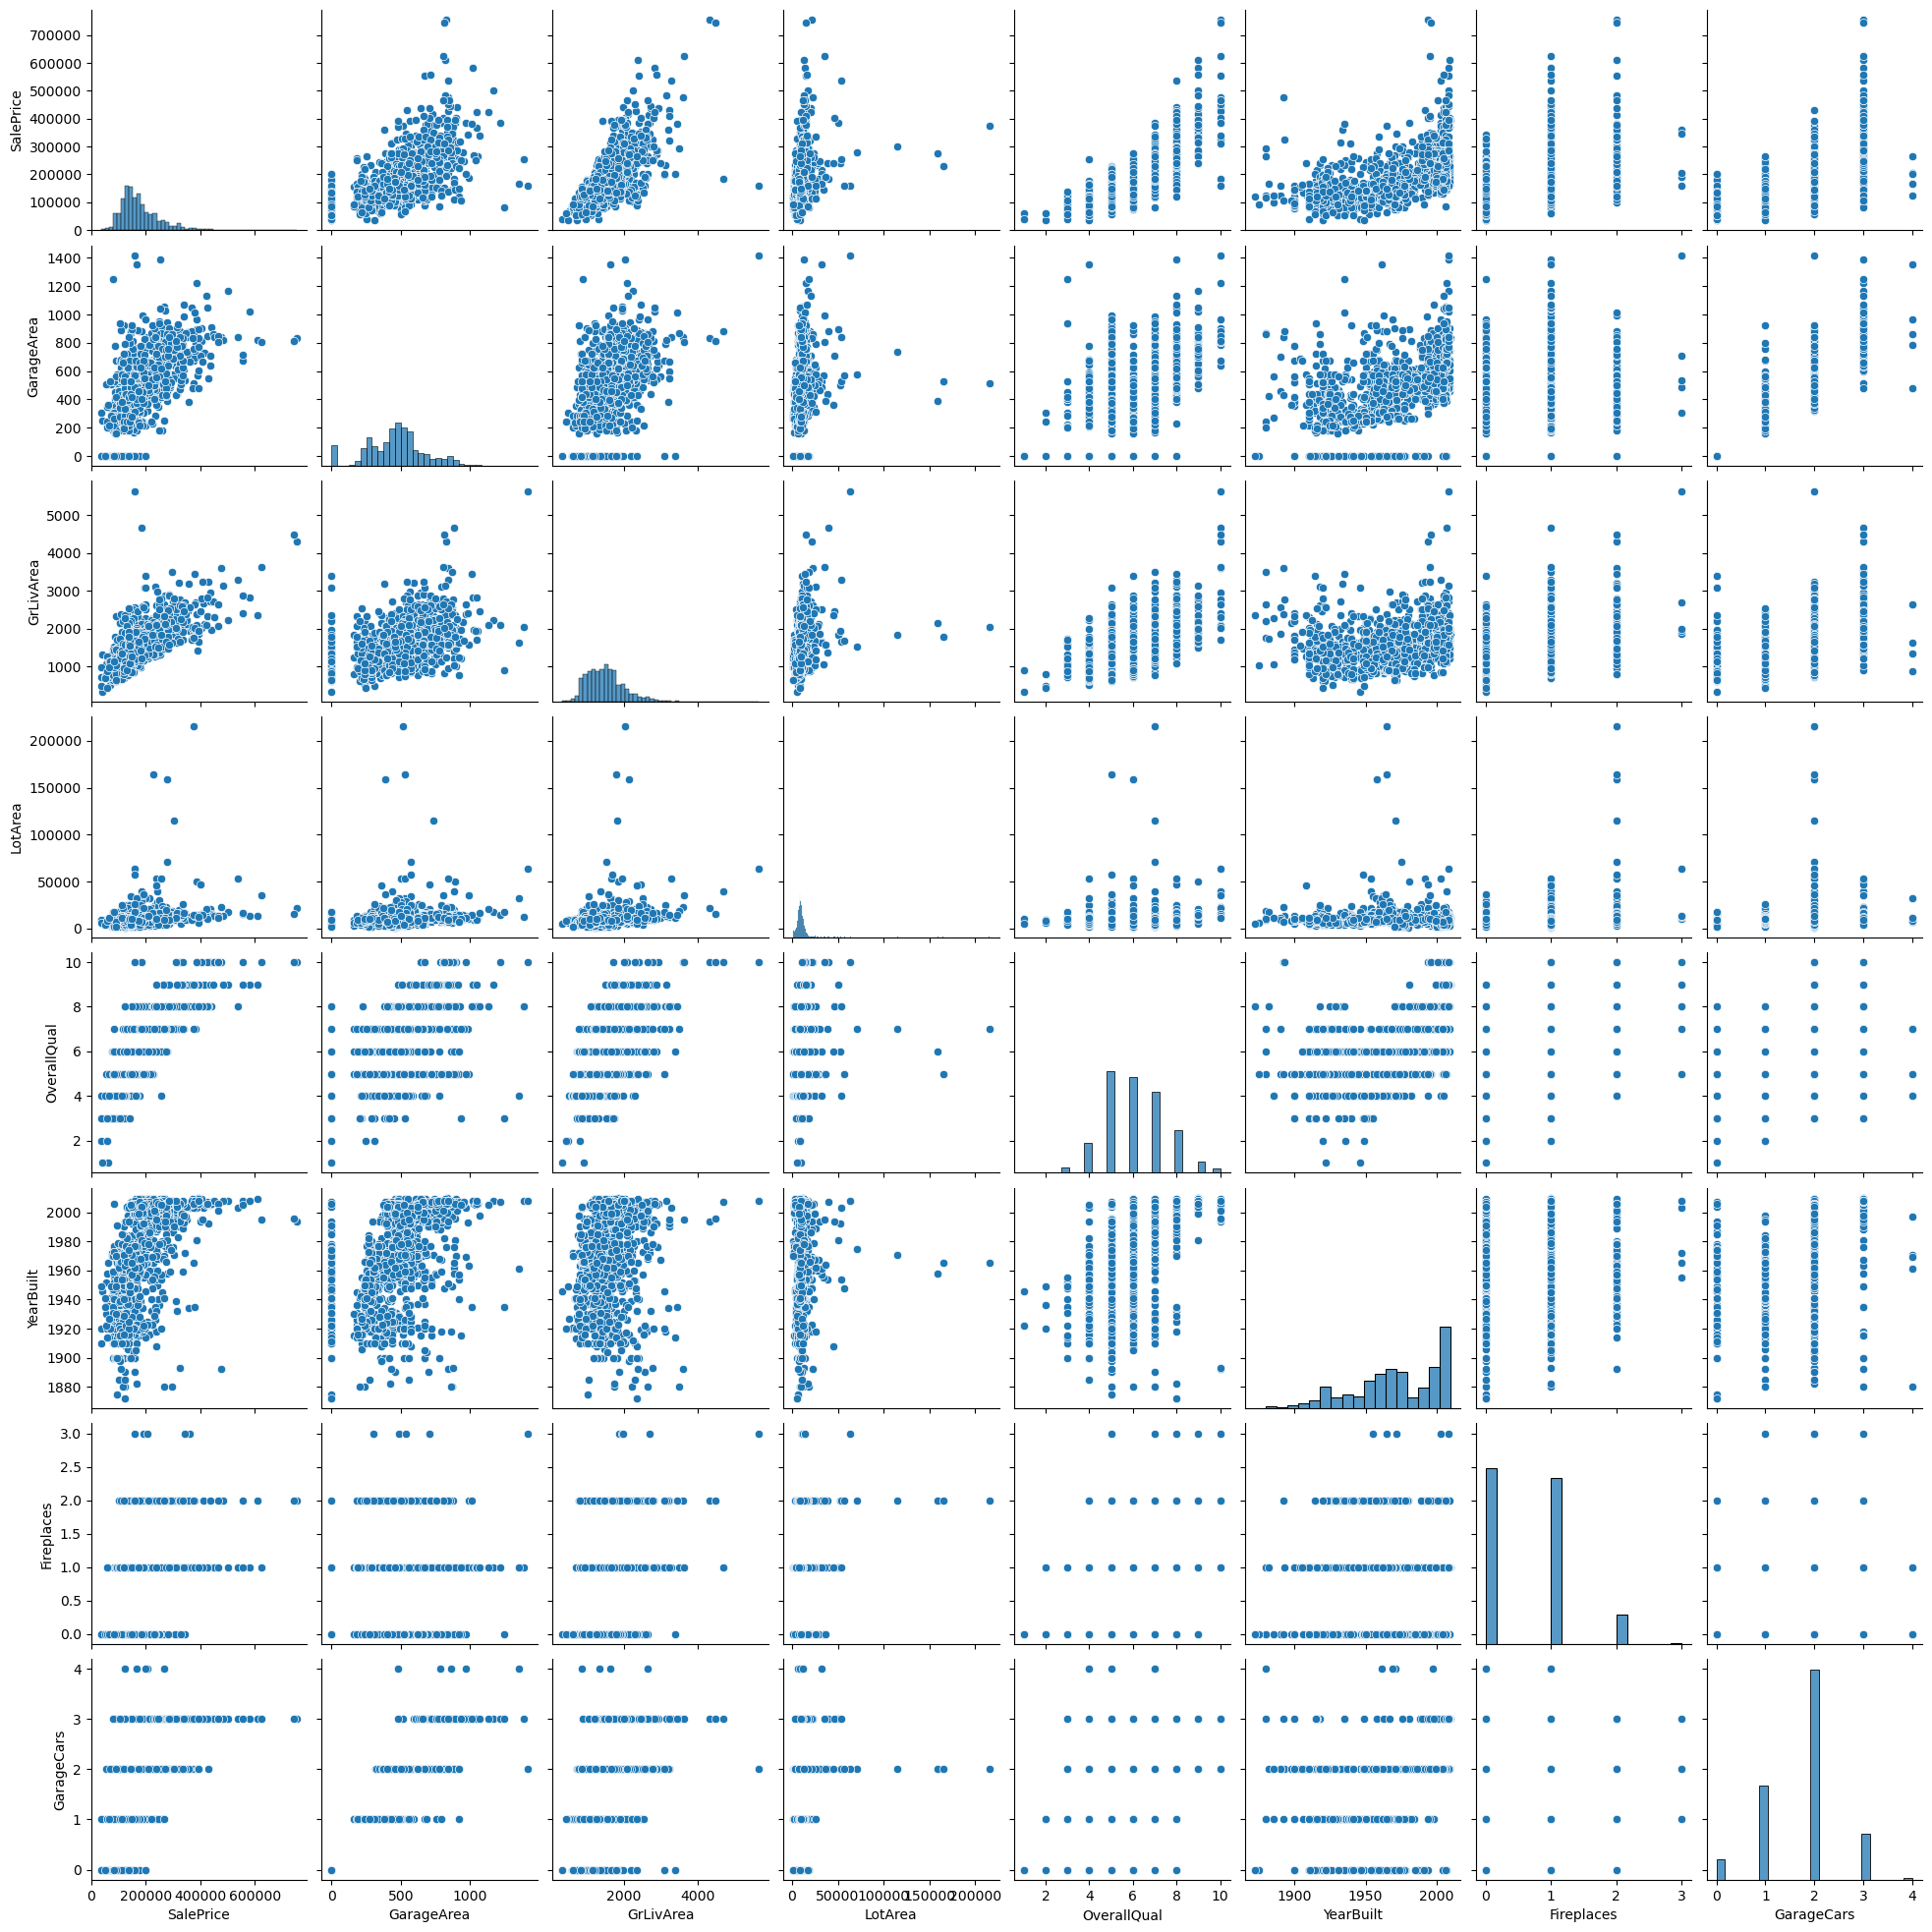

In [580]:
# Check the linear relationship between target (y) and predictor (X) variables.
#LR is useful only if a linear relationship exists between X & y

#As the dataset is very huge, we will check the linear relationship between a few numerical variables and the target variable

sns.pairplot(housing, vars=['SalePrice','GarageArea','GrLivArea','LotArea','OverallQual','YearBuilt','Fireplaces','GarageCars'])
plt.show()

There is a linear relationship between independent and dependent variable. Hence LR is possible.

### 2. Data Preparation - 1

- Impute missing values for numeric variables 

In [581]:
#Make a copy of dataset
housing1 = housing.copy()

# Out of the variables with missing values identified above, the numeric variables are: 
#GarageYrBlt
#LotFrontage
#MasVnrArea

housing1.LotFrontage.describe() # Check mean value

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [582]:
#Impute missing values with average value for LotFrontage.
#It has to be replaced with mean value 

print('Before imputation:',housing1['LotFrontage'].isna().sum())

housing1['LotFrontage'].fillna((housing1['LotFrontage'].mean()), inplace=True)

print('After imputation:',housing1['LotFrontage'].isna().sum())

Before imputation: 259
After imputation: 0


In [583]:
print('Before imputation:',housing1['GarageYrBlt'].isna().sum())

#GarageYrBlt is null for those houses which doesn't have a garage. There are 81 records (5.45% of total records)
#These can be imputed with 0

housing1['GarageYrBlt'].fillna(0, inplace=True)

print('After imputation:',housing1['GarageYrBlt'].isna().sum())

Before imputation: 81
After imputation: 0


In [584]:
print('Before imputation:',housing1['MasVnrArea'].isna().sum())

#MasVnrArea - Masonry veneer area in square feet is null for 8 records
#These can be imputed with mean value

housing1['MasVnrArea'].fillna((housing1['MasVnrArea'].mean()), inplace=True)

print('After imputation:',housing1['MasVnrArea'].isna().sum())

Before imputation: 8
After imputation: 0


In [585]:
#Take the list of categorical variables with missing values
n_pct = n_pct[~n_pct['column'].isin(['LotFrontage','MasVnrArea','GarageYrBlt'])]

n_pct.head(20)

,column,pct
24,MasVnrType,0.547945
29,BsmtQual,2.534247
30,BsmtCond,2.534247
31,BsmtExposure,2.602740
32,BsmtFinType1,2.534247
34,BsmtFinType2,2.602740
41,Electrical,0.068493
56,FireplaceQu,47.260274
57,GarageType,5.547945
59,GarageFinish,5.547945


In [586]:
#Create a list of categorical variables with null values from n_pct dataframe
cat_vars = n_pct['column'].to_list()

print(cat_vars)

#Impute the missing values with mode value of each categorical variable

housing1[cat_vars] = housing1[cat_vars].apply(lambda x: x.fillna(x.mode()[0]))

['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


In [587]:
#Check again for  columns having null values
null_pct1 = (housing1.isnull().sum() / len(housing1.index))*100
n_pct1 = pd.DataFrame({'column':null_pct1.index, 'pct':null_pct1.values})

n_pct1 = n_pct1[n_pct1['pct'].apply(lambda x: x>0.0)]

n_pct1.head(30) 

,column,pct


In [588]:
# convert 'MSSubClass' to categorical variable
housing1['MSSubClass'] = housing1['MSSubClass'].astype('object')

#### Derived variable
A new variable - TotalBuiltUpArea can be created as sum of:
- TotalBsmtSF: Total square feet of basement area
- GrLivArea: Above grade (ground) living area square feet
- GarageArea: Size of garage in square feet

And we can drop these 3 variables as they become redundant ones, creating multicollinearity
- GarageArea will be of better business value here, but since the GarageCars (Size of garage in car capacity) is giving the same information, we can drop GarageArea

In [589]:
housing1['TotalBuiltUpArea'] = housing1['GrLivArea'] + housing1['GarageArea'] + housing1['TotalBsmtSF']

housing1 = housing1.drop(['GrLivArea', 'GarageArea','TotalBsmtSF'], axis=1)

In [590]:
#BsmtQual: Evaluates the height of the basement
# This variable can be converted to a numeric variable by substituting the minimum height of basement given in data dictionary
#       Ex	Excellent (100+ inches)	 = 100
#       Gd	Good (90-99 inches)      = 90
#       TA	Typical (80-89 inches)   = 80
#       Fa	Fair (70-79 inches)      = 70
#       Po	Poor (<70 inches         = 60
#       NA	No Basement              = 0

housing1.BsmtQual = housing1.BsmtQual.apply(lambda x: 100 if x=='Ex' else (90 if x=='Gd' else (80 if x=='TA' else (70 if x=='Fa' else (60 if x=='Po' else 0)))))

housing1.BsmtQual.describe()

count    1460.000000
mean       85.650685
std         6.780705
min        70.000000
25%        80.000000
50%        90.000000
75%        90.000000
max       100.000000
Name: BsmtQual, dtype: float64

If build quality is good, then the current condition is something which can be altered. So quality have more weightage and it also makes 'condition a redundant data point.

Also, from a real estate business perspective, the built quality is more important. If the quality is good, then current condition is something which can be improved with minimum expenditure.

With this understanding, we can take follwing decisions:
- GarageCond can be dropped as GarageQual is also available
- BsmtCond can be dropped as BsmtQual is also available
- ExterCond can be dropped as ExterQual is also available
- OverallCond can be dropped as OverallQual is also available

In [591]:
housing1 = housing1.drop(['GarageCond', 'BsmtCond','ExterCond', 'OverallCond'], axis=1)

housing1.shape

(1460, 70)

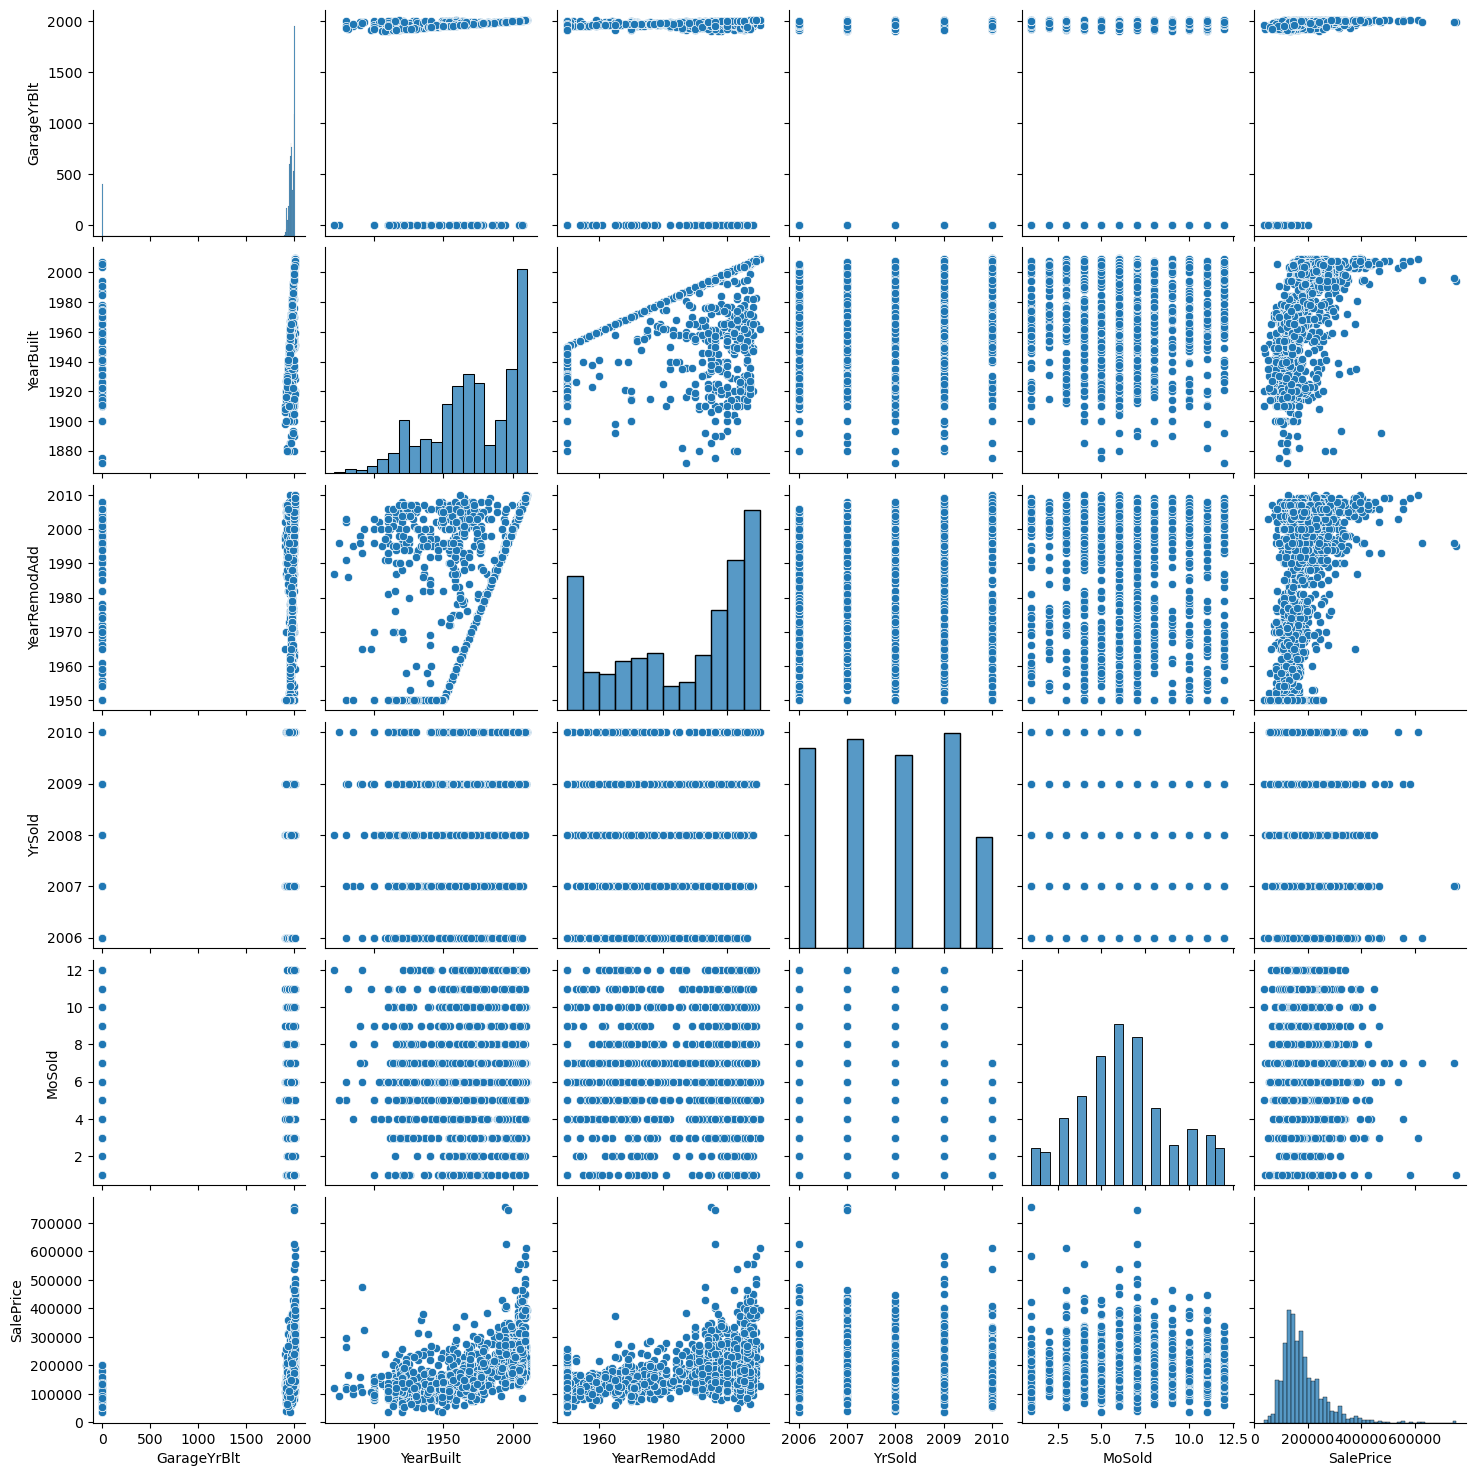

In [592]:
#Check the relation between various date/year to the sale price to see if there is any value addition by date variables
sns.pairplot(housing1, vars=['GarageYrBlt','YearBuilt','YearRemodAdd','YrSold','MoSold', 'SalePrice'])
plt.show()


We can see that 'YearBuilt' and 'YearRemodAdd' have a slight linear relationship with SalePrice but other variables didn't have any. So those can be dropped

In [593]:
housing1 = housing1.drop(['GarageYrBlt', 'YrSold','MoSold'], axis=1)

housing1.shape

(1460, 67)

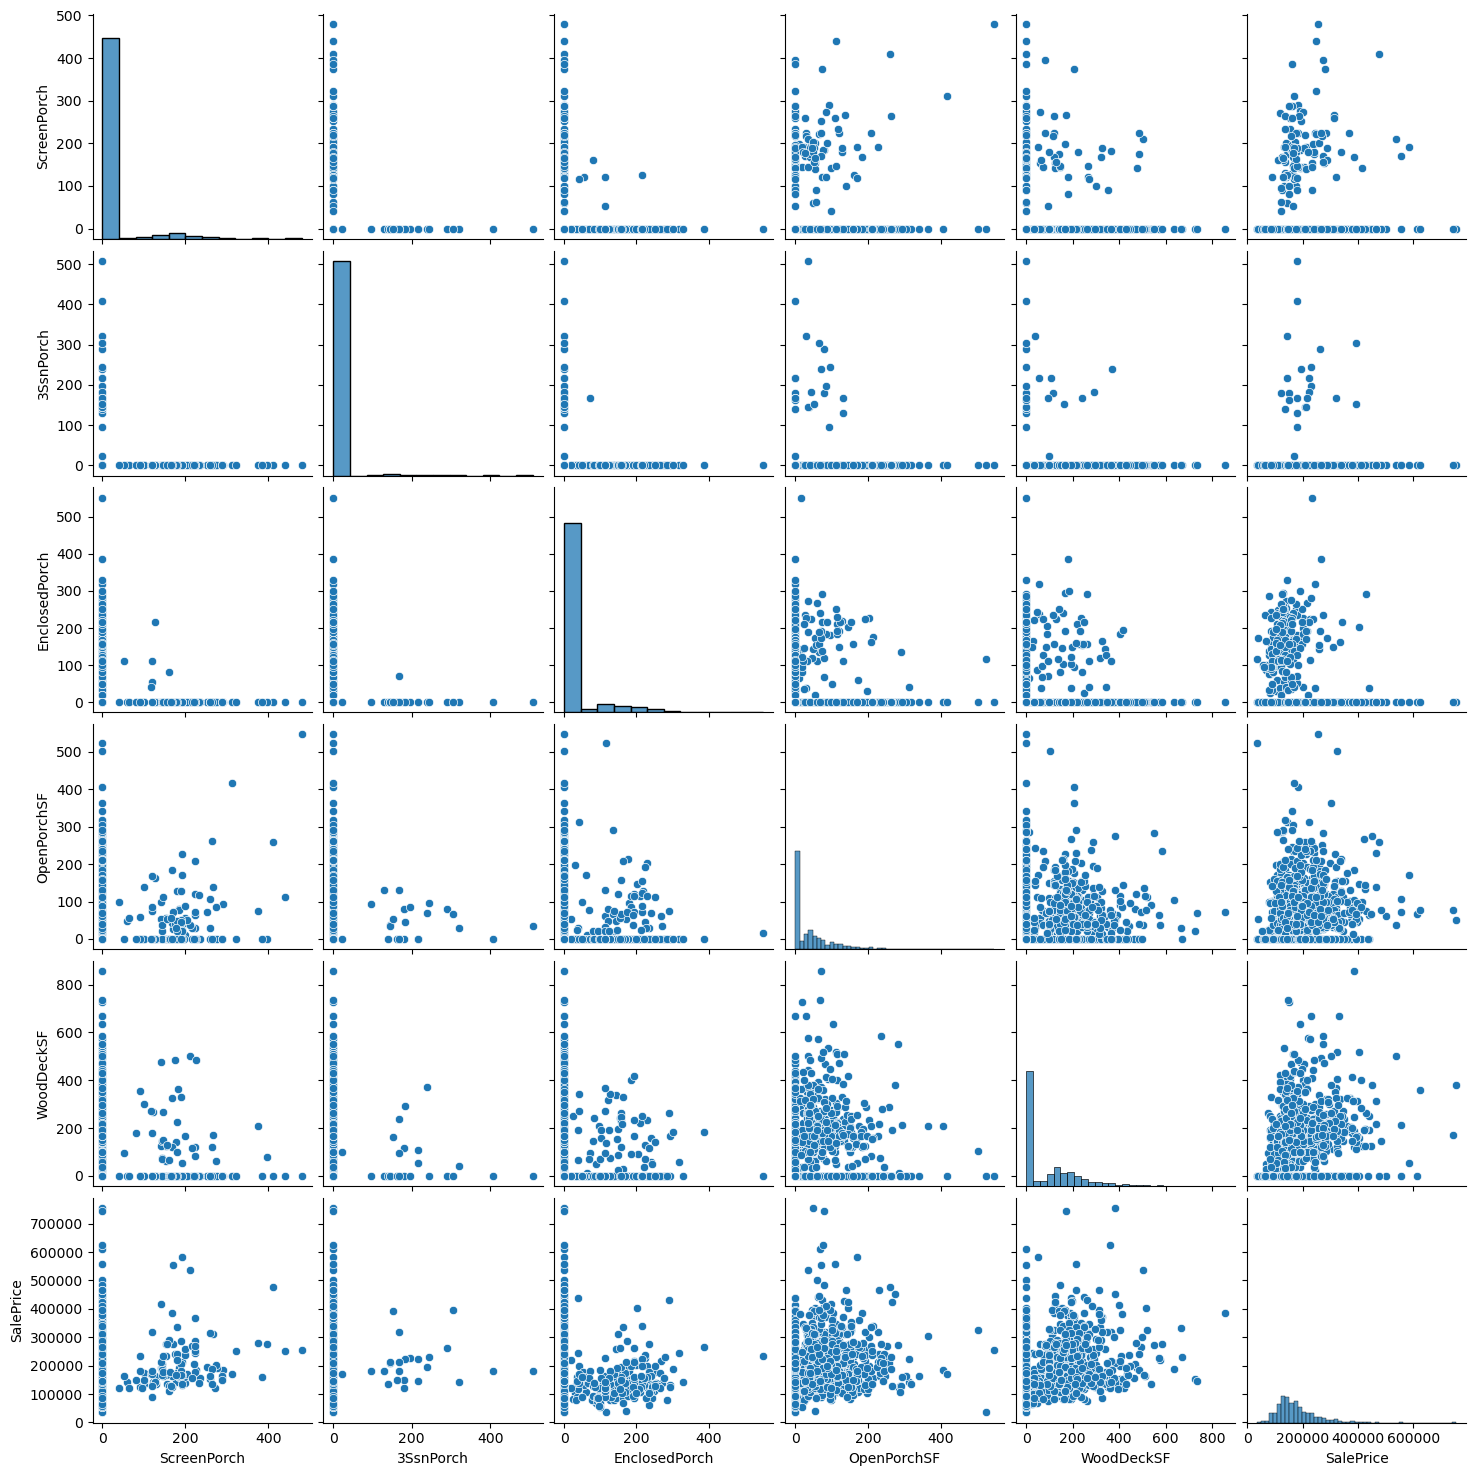

In [594]:
#Check the relation between various porch areas to the sale price to see if there is any value addition by these variables
sns.pairplot(housing1, vars=['ScreenPorch','3SsnPorch','EnclosedPorch','OpenPorchSF','WoodDeckSF', 'SalePrice'])
plt.show()

'ScreenPorch','3SsnPorch' & 'EnclosedPorch' doesn't seem to have any linear relationship with SalePrice whereas 'OpenPorchSF'&'WoodDeckSF' are showing linear relationship.
Hence 'ScreenPorch','3SsnPorch' & 'EnclosedPorch' can be dropped

In [595]:
housing1 = housing1.drop(['ScreenPorch','3SsnPorch' ,'EnclosedPorch'], axis=1)

print(housing1.shape)
print(housing1.columns)

(1460, 64)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars',
       'GarageQual', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea',
       'SaleType', 'SaleCondition', 'SalePrice', 'TotalBuiltUpArea'],
      dty

Label encoding for relative categorical variables:
- There are multiple categorical variables which represents relative variables - especially the ones representing quality of an aspect of the house.
- These can be numerically encoded using ascending integers, starting from 1, where 1 represents poorest quality of the feature and the highest integer representing highest quality of the aspect the variable represents. 0 represents absence of that feature.

In [596]:
print(housing1.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars',
       'GarageQual', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea',
       'SaleType', 'SaleCondition', 'SalePrice', 'TotalBuiltUpArea'],
      dtype='object'

In [597]:
#ExterQual: Evaluates the quality of the material on the exterior 
#Ex	Excellent       = 5
#Gd	Good            = 4
#TA	Average/Typical = 3
#Fa	Fair            = 2
#Po	Poor            = 1

housing1.ExterQual = housing1.ExterQual.apply(lambda x: 5 if x=='Ex' else (4 if x=='Gd' else (3 if x=='TA' else (2 if x=='Fa' else 1))))

housing1.ExterQual.describe()

count    1460.00000
mean        3.39589
std         0.57428
min         2.00000
25%         3.00000
50%         3.00000
75%         4.00000
max         5.00000
Name: ExterQual, dtype: float64

In [598]:
#HeatingQC: Heating quality and condition
#Ex	Excellent       = 5
#Gd	Good            = 4
#TA	Average/Typical = 3
#Fa	Fair            = 2
#Po	Poor            = 1

housing1.HeatingQC = housing1.HeatingQC.apply(lambda x: 5 if x=='Ex' else (4 if x=='Gd' else (3 if x=='TA' else (2 if x=='Fa' else 1))))

housing1.HeatingQC.describe()

count    1460.000000
mean        4.145205
std         0.959501
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: HeatingQC, dtype: float64

In [599]:
#KitchenQual: Kitchen quality
#Ex	Excellent       = 5
#Gd	Good            = 4
#TA	Average/Typical = 3
#Fa	Fair            = 2
#Po	Poor            = 1

housing1.KitchenQual = housing1.KitchenQual.apply(lambda x: 5 if x=='Ex' else (4 if x=='Gd' else (3 if x=='TA' else (2 if x=='Fa' else 1))))

housing1.KitchenQual.describe()

count    1460.000000
mean        3.511644
std         0.663760
min         2.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: KitchenQual, dtype: float64

In [600]:
#FireplaceQu: Fireplace quality
#Ex	Excellent       = 5
#Gd	Good            = 4
#TA	Average/Typical = 3
#Fa	Fair            = 2
#Po	Poor            = 1
#NA	No Fireplace    = 0

housing1.FireplaceQu = housing1.FireplaceQu.apply(lambda x: 5 if x=='Ex' else (4 if x=='Gd' else (3 if x=='TA' else (2 if x=='Fa' else (1 if x=='Po' else 0 )))))

housing1.FireplaceQu.describe()

count    1460.000000
mean        3.715753
std         0.603302
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: FireplaceQu, dtype: float64

In [601]:
#GarageQual: Garage quality
#Ex	Excellent       = 5
#Gd	Good            = 4
#TA	Average/Typical = 3
#Fa	Fair            = 2
#Po	Poor            = 1
#NA	No Garage       = 0

housing1.GarageQual = housing1.GarageQual.apply(lambda x: 5 if x=='Ex' else (4 if x=='Gd' else (3 if x=='TA' else (2 if x=='Fa' else (1 if x=='Po' else 0 )))))

housing1.GarageQual.describe()

count    1460.000000
mean        2.976712
std         0.241665
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: GarageQual, dtype: float64

### 3. Exploratory Data Analysis

- Univariate Analysis

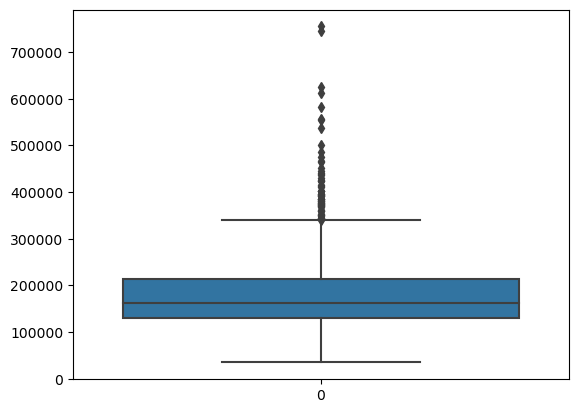

In [602]:
#Check the distribution of target variable:

sns.boxplot(housing1['SalePrice'])
plt.show()

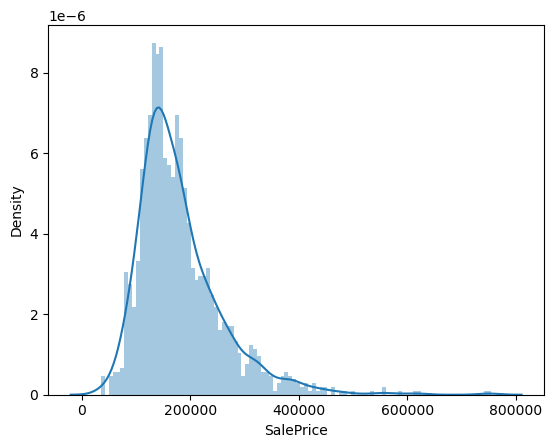

In [603]:
sns.distplot(housing1['SalePrice'], bins=100)
plt.show()

Slight right skewness in the target variable distribution.

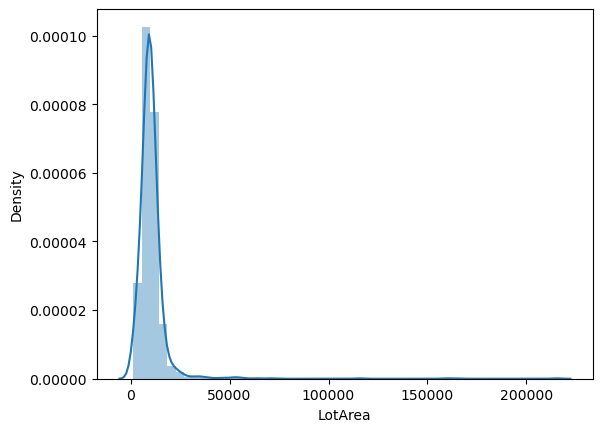

In [604]:
#LotArea - total size in sqft

sns.distplot(housing1['LotArea'])
plt.show()

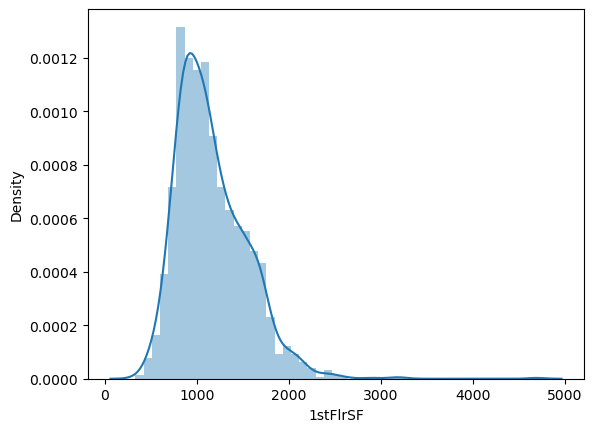

In [605]:
#1stFlrSF - First Floor square feet

sns.distplot(housing1['1stFlrSF'])
plt.show()


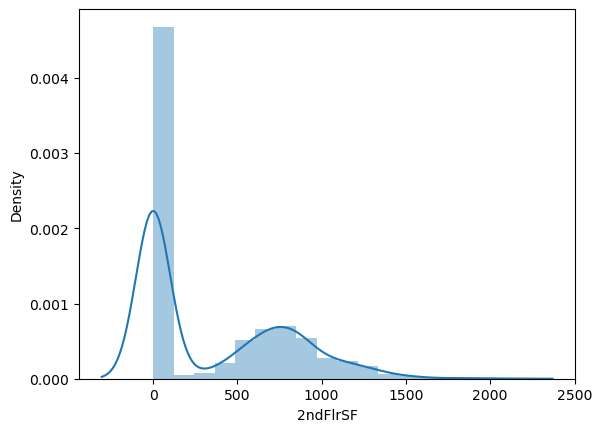

In [606]:
#2ndFlrSF - Second floor square feet
sns.distplot(housing1['2ndFlrSF']) # peak at 0 represents the houses without 2nd floor
plt.show()

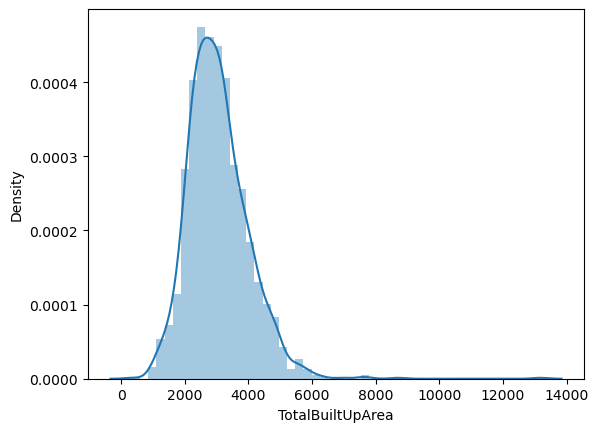

In [607]:
#TotalBuiltUpArea
sns.distplot(housing1['TotalBuiltUpArea']) 
plt.show()

#### Unvariate - Visualising categorical variables

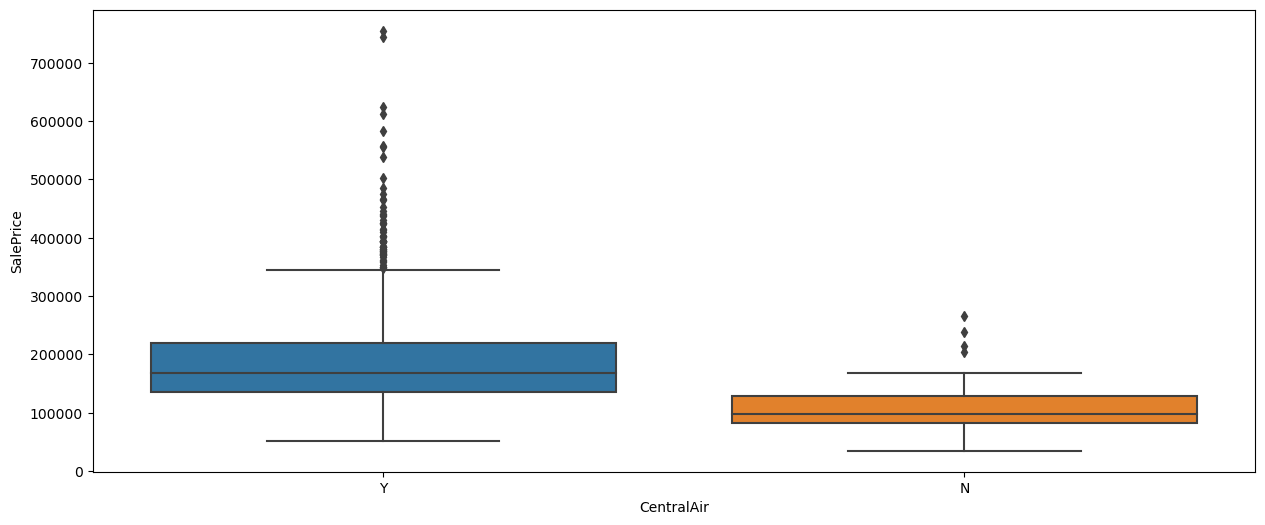

In [608]:
#Boxplot analysis for categorical variables with two categories:

plt.figure(figsize=(15, 6))
sns.boxplot(x = 'CentralAir', y = 'SalePrice', data = housing1)

plt.show()

In [609]:
#Let us check how 'LandContour' is related to the saleprice

land_cont_dist = pd.pivot_table(housing1, index='LandContour', values='SalePrice', aggfunc=np.mean)

#convert pivot table to a dataframe
land_cont_dist = pd.DataFrame(land_cont_dist.to_records())
land_cont_dist

,LandContour,SalePrice
0,Bnk,143104.079365
1,HLS,231533.940000
2,Low,203661.111111
3,Lvl,180183.746758


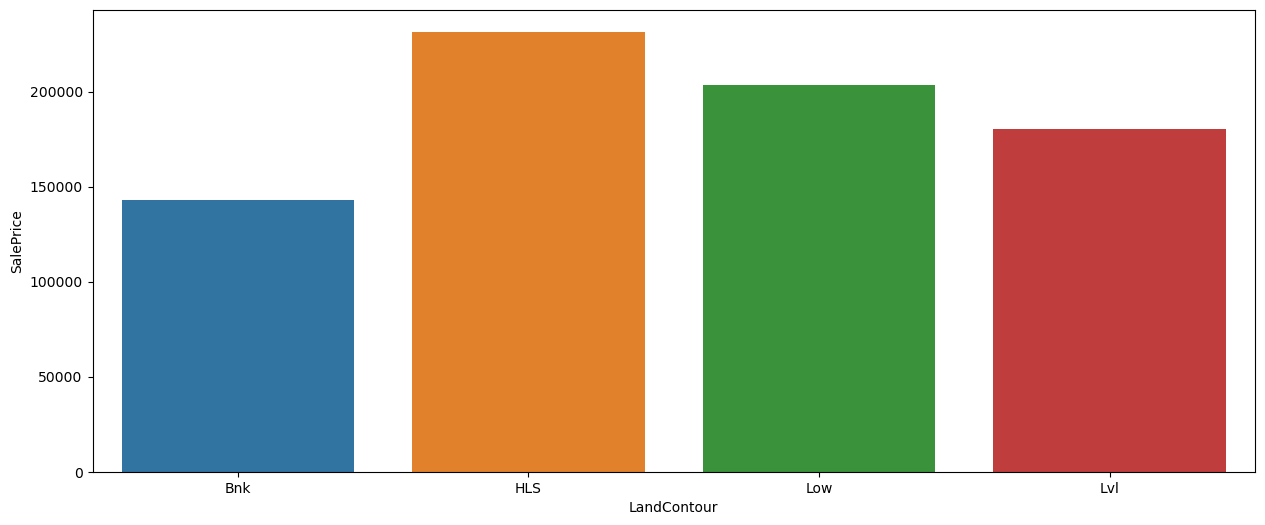

In [610]:
plt.figure(figsize=(15, 6))
sns.barplot(x='LandContour', y='SalePrice', data= land_cont_dist)
plt.show()

#### Bivariate EDA


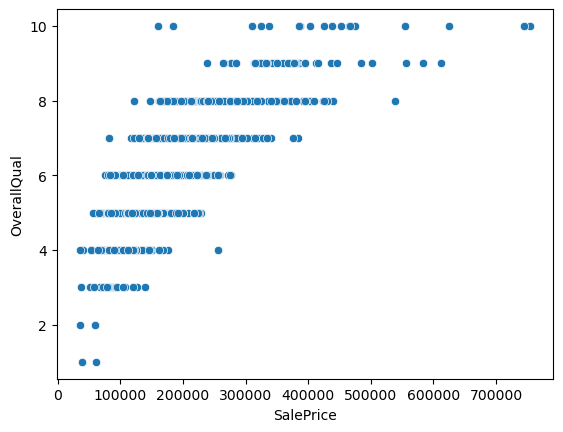

In [611]:
#Sale price Vs Overall Quality of house
sns.scatterplot(data=housing1, x='SalePrice', y='OverallQual')
plt.show()

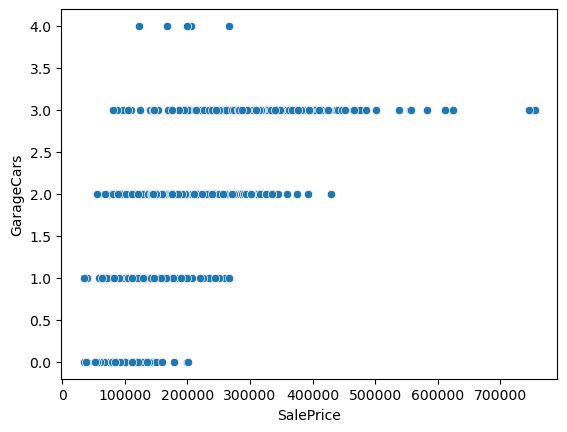

In [612]:
#Sale price Vs Number of cars that can be parked in the garage
sns.scatterplot(data=housing1, x='SalePrice', y='GarageCars')
plt.show()

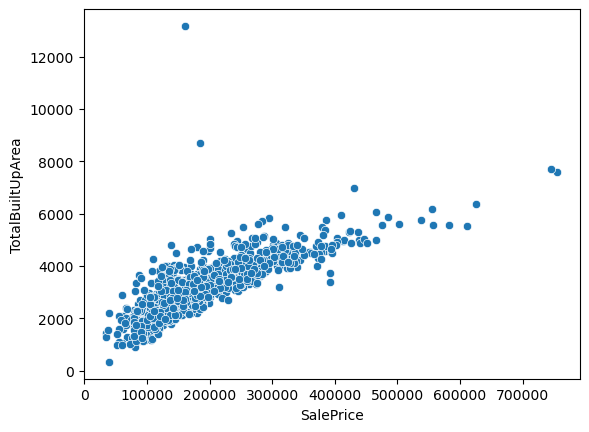

In [613]:
#Sale price Vs Total builtup area

sns.scatterplot(data=housing1, x='SalePrice', y='TotalBuiltUpArea')
plt.show()

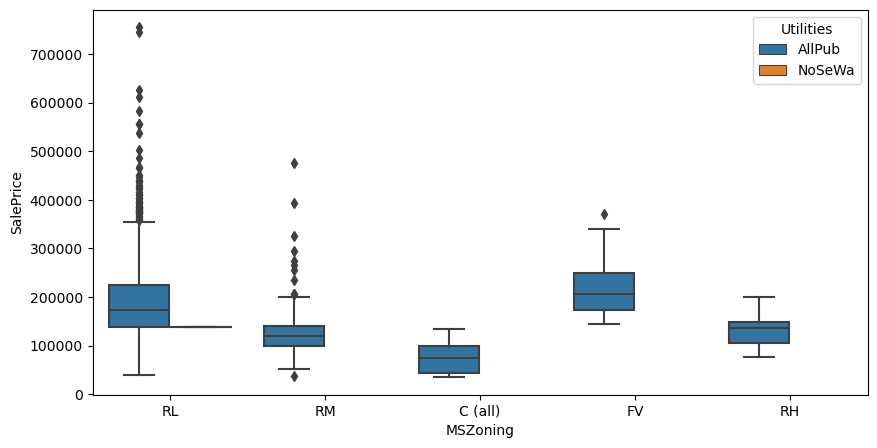

In [614]:
#Visualising categorical variables parallely using hue argument in boxplot

plt.figure(figsize = (10, 5))
sns.boxplot(x = 'MSZoning', y = 'SalePrice', hue = 'Utilities', data = housing1)
plt.show()

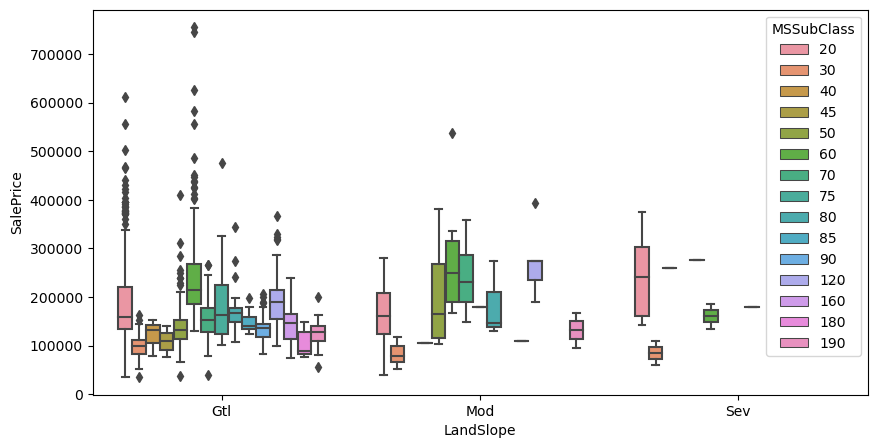

In [615]:
#Visualising categorical variables parallely using hue argument in boxplot

plt.figure(figsize = (10, 5))
sns.boxplot(x = 'LandSlope', y = 'SalePrice', hue = 'MSSubClass', data = housing1)
plt.show()

### 4. Data Preparation - 2

- Replace 'yes' or 'no' values with 1 & 0 respectively

In [616]:
housing1.CentralAir.describe()

count     1460
unique       2
top          Y
freq      1365
Name: CentralAir, dtype: object

In [617]:
bi_vars =  ['CentralAir']

def binary_map(x):
    return x.map({'Y': 1, "N": 0})

housing1[bi_vars] = housing1[bi_vars].apply(binary_map)

housing1.CentralAir.head()

0    1
1    1
2    1
3    1
4    1
Name: CentralAir, dtype: int64

In [618]:
# creating dummy variables for categorical variables

# subset all categorical variables
housing1_cat_vars = housing1.select_dtypes(include=['object'])
housing1_cat_vars.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Electrical',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [619]:
#Basement exposure is also a relative categorical variable and thus label encoding can be done to convert it to numeric variable
#BsmtExposure: Refers to walkout or garden level walls
#Gd	Good Exposure                                                               = 4
#Av	Average Exposure (split levels or foyers typically score average or above)	= 3
#Mn	Mimimum Exposure                                                            = 2
#No	No Exposure                                                                 = 1
#NA	No Basement                                                                 = 0

housing1.BsmtExposure = housing1.BsmtExposure.apply(lambda x: 4 if x=='Gd' else (3 if x=='Av' else (2 if x=='Mn' else (1 if x=='No' else 0))))

housing1.BsmtExposure.describe()

count    1460.000000
mean        1.656164
std         1.039123
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: BsmtExposure, dtype: float64

In [620]:
#Home functionality is also a relative categorical variable which can be labelled as below:
#Functional: Home functionality (Assume typical unless deductions are warranted)
#Typ	Typical Functionality   = 7
#Min1	Minor Deductions 1      = 6
#Min2	Minor Deductions 2      = 5
#Mod	Moderate Deductions     = 4
#Maj1	Major Deductions 1      = 3 
#Maj2	Major Deductions 2      = 2
#Sev	Severely Damaged        = 1
#Sal	Salvage only            = 0

housing1.Functional = housing1.Functional.apply(lambda x: 7 if x=='Typ' else (6 if x=='Min1' else (5 if x=='Min2' else (4 if x=='Mod' else (3 if x=='Maj1' else (2 if x== 'Maj2' else (1 if x=='Sev' else 0)) )))))

housing1.Functional.describe()

count    1460.000000
mean        6.841781
std         0.667698
min         1.000000
25%         7.000000
50%         7.000000
75%         7.000000
max         7.000000
Name: Functional, dtype: float64

In [621]:
# Get the updated list of categorical variables
housing1_cat_vars = housing1.select_dtypes(include=['object'])
housing1_cat_vars.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Electrical', 'GarageType',
       'GarageFinish', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [622]:
housing1_cat_vars.info() # 27 categorical variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   MSZoning       1460 non-null   object
 2   Street         1460 non-null   object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1460 non-null   object
 18  Foundation     1460 non-null

In [623]:
# Create dummy variables (one hot encoding)
housing1_dummies = pd.get_dummies(housing1_cat_vars, drop_first=True)
housing1_dummies.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [624]:
# drop categorical variables from X and add the dummy variables to X
housing1 = housing1.drop(list(housing1_cat_vars.columns), axis=1)
housing1 = pd.concat([housing1, housing1_dummies], axis=1)

In [625]:
housing1.head()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,2003,2003,196.0,4,90,1,...,0,0,0,0,1,0,0,0,1,0
1,2,80.0,9600,6,1976,1976,0.0,3,90,4,...,0,0,0,0,1,0,0,0,1,0
2,3,68.0,11250,7,2001,2002,162.0,4,90,2,...,0,0,0,0,1,0,0,0,1,0
3,4,60.0,9550,7,1915,1970,0.0,3,80,1,...,0,0,0,0,1,0,0,0,0,0
4,5,84.0,14260,8,2000,2000,350.0,4,90,3,...,0,0,0,0,1,0,0,0,1,0


### 4. Model Building

In [626]:
#Splitting the data into X and y
X = housing1.copy()
print(X.shape)
X = X.drop('SalePrice', axis=1)
print(X.shape)
y = housing1['SalePrice']

(1460, 208)
(1460, 207)


In [627]:
X.head()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,2003,2003,196.0,4,90,1,...,0,0,0,0,1,0,0,0,1,0
1,2,80.0,9600,6,1976,1976,0.0,3,90,4,...,0,0,0,0,1,0,0,0,1,0
2,3,68.0,11250,7,2001,2002,162.0,4,90,2,...,0,0,0,0,1,0,0,0,1,0
3,4,60.0,9550,7,1915,1970,0.0,3,80,1,...,0,0,0,0,1,0,0,0,0,0
4,5,84.0,14260,8,2000,2000,350.0,4,90,3,...,0,0,0,0,1,0,0,0,1,0


In [628]:
print(y)

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
30       40000
31      149350
32      179900
33      165500
34      277500
35      309000
36      145000
37      153000
38      109000
39       82000
40      160000
41      170000
42      144000
43      130250
44      141000
45      319900
46      239686
47      249700
48      113000
49      127000
50      177000
51      114500
52      110000
53      385000
54      130000
55      180500
56      172500
57      196500
58      438780
59      124900
60      158000
61      101000
62      202500
63      140000
64      219500
65      317000
66      18

In [629]:
#Scaling the variables
from sklearn.preprocessing import scale

cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.head()

,Id,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,BsmtQual,BsmtExposure,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-1.730865,-0.229372,-0.207142,0.651479,1.050994,0.878668,0.511418,1.052302,0.641645,-0.631676,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
1,-1.728492,0.451936,-0.091886,-0.071836,0.156734,-0.429577,-0.574410,-0.689604,0.641645,2.256363,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
2,-1.726120,-0.093110,0.073480,0.651479,0.984752,0.830215,0.323060,1.052302,0.641645,0.331004,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995
3,-1.723747,-0.456474,-0.096897,0.651479,-1.863632,-0.720298,-0.574410,-0.689604,-0.833633,-0.631676,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995
4,-1.721374,0.633618,0.375148,1.374795,0.951632,0.733308,1.364570,1.052302,0.641645,1.293683,...,-0.058621,-0.058621,-0.301962,-0.045376,0.390293,-0.052414,-0.091035,-0.117851,0.467651,-0.305995


In [630]:
#Scaling the target variable
y = scale(y)
y

array([ 0.34727322,  0.00728832,  0.53615372, ...,  1.07761115,
       -0.48852299, -0.42084081])

In [631]:
#Train - test split (70-30)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)



To avoid overfitting we will build the regression model using regularization methods. 
- 1. We will first build a LR model using all features, without performing an feature selection.
- Model evaluation using VIF will help to understand the multicollinearity

We will be building 2 different models using both Ridge & Lasso regression methods.
- 2. Ridge regression model using cross validation for model evaluation and hyperparameter tuning will be built first.
- 3. Then another model will be built using Lasso regression with cross validation for model evaluation and hyperparameter tuning. Lasso will force some of the coefficients to zero, therby giving us a set of higly significant variables with non zero coefficient values.


#### Linear regression using all independent variables (Without feature selection)

In [632]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [633]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-2985904818.6149206
[ 3.44317983e-03  4.08398469e-02  6.80869286e-02  1.34768368e-01
  4.87734012e-02  4.67103431e-02  6.28851269e-02  4.36608892e-02
  5.40600979e-02  8.08218992e-02  1.79912780e-01  1.49323948e-02
  4.18933387e-02  1.03783833e-02 -2.88065907e-03  2.49009997e-01
  3.86076566e-01  8.41277136e-03  5.36365268e-03 -5.52185179e-04
 -8.51164089e-03 -1.07724314e-02 -4.86383804e-02 -4.27826696e-02
  4.00241125e-02  2.21494531e-02  6.31145025e-02  1.70123089e-02
  2.25987490e-02  1.22799781e-02  2.76662479e-02  5.15549678e-03
  2.16511711e-02  5.37012840e-02  1.20842137e-01 -1.44795347e-03
  8.70502388e-04 -1.10458636e-02  1.01958080e-03  1.89596560e-02
 -8.31033893e-03 -7.09057976e-02 -3.25354451e-02 -2.45827690e-03
 -5.90507075e+10 -4.22370987e-02 -2.61408346e-02 -1.81592283e-02
  6.06571037e+10  9.01548364e-02  5.16860690e-02  2.01849153e-01
  1.51132894e-01  1.27487314e-02  4.36162777e-04 -6.34490306e-03
  1.27183990e-02  2.11751914e-02 -1.20093481e-02  1.62170456e-02
 -2.5

In [634]:
#Evaluate the model using test dataset and then compare the statistical parameters

y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print('LR Train R2 score:', r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print('LR Test R2 score:',r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print('LR Train RSS:', rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print('LR Test RSS:', rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print('LR Train MSE:', mse_train_lr)
metric.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print('LR Test MSE:',mse_test_lr)
metric.append(mse_test_lr)

#Calculating residual values
res_lr_train = y_train - y_pred_train
res_lr_test = y_test - y_pred_test

LR Train R2 score: 0.9342751126170072
LR Test R2 score: -1.544751326438583e+22
LR Train RSS: 66.49512732908597
LR Test RSS: 6.904004884867332e+24
LR Train MSE: 0.06512745086100487
LR Test MSE: 1.5762568230290711e+22


Above model evaluation shows that the LR model without feature selection is clearly overfitting. 

Reason for overfitting:
- Model is too complex, having 250 independent variables
- Coefficient values are large and uneven


To tackle the problem of overfitting, we will now build LR models with regularisation




In [635]:
X_train.shape

(1021, 207)

#### Ridge regression model

- We will be using K-folds with Gridsearch CV method for model evaluation and hyperparameter (alpha) tuning

In [636]:
#There are 1021 records in the training dataset. We will go for K=5 folds and various values of alpha

params = {'alpha': [0.01, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 50, 100, 500, 1000, 10000]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,
                                   9.0, 10.0, 50, 100, 500, 1000, 10000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [637]:
# Applying Ridge Regression with varying the hyperparameter 'lambda'

X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1) # values to be considered for predictor variable
lambdas = [0.01, 0.1, 1, 10, 100, 500, 1000] # Higher the value of lambda, 
                                                  # more the regularization
for i in lambdas: # for each lambda we get different model coefficients
    ridge = Ridge(alpha=i)
    ridge.fit(X_train, y_train) # fit the model on the polynomial features

    #Computing the r2 score
    
    y_pred_test = ridge.predict(X_test)
    print("Ridge r2 score for lambda = ", i , ": " + str(r2_score(y_test, y_pred_test))) 
    

Ridge r2 score for lambda =  0.01 : 0.8142434090821739
Ridge r2 score for lambda =  0.1 : 0.8147643396897244
Ridge r2 score for lambda =  1 : 0.8192360145997933
Ridge r2 score for lambda =  10 : 0.8360807082751132
Ridge r2 score for lambda =  100 : 0.8502458525596831
Ridge r2 score for lambda =  500 : 0.8528262392548609
Ridge r2 score for lambda =  1000 : 0.8410237101313965


In [638]:
# Check the best alpha value selected b gridsearch CV

print(model_cv.best_params_)

{'alpha': 500}


In [639]:
#Fitting the ridge model for best alpha value obtained
alp =500.0
ridge = Ridge(alpha=alp)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-4.70073748e-03  1.27443617e-02  3.49960485e-02  1.04720955e-01
  8.27705323e-03  3.57451128e-02  5.35809159e-02  5.19834610e-02
  6.20044068e-02  6.38888531e-02  3.61698923e-02  1.01034717e-02
  7.34758064e-03  2.03782104e-02  1.24103851e-02  8.12332784e-02
  6.66817779e-02 -4.45506890e-03  2.85848333e-02  4.25934211e-03
  5.00557688e-02  2.67627164e-02  7.48019046e-03 -2.01144686e-02
  6.19503693e-02  6.07947912e-02  2.61491901e-02  5.39815581e-02
  2.51324787e-02  5.87708496e-02  1.93548204e-02  2.31064656e-02
  1.29457493e-02  3.17940697e-03  9.68269479e-02 -6.97583380e-03
  2.52306500e-03 -7.41420982e-04  8.48235002e-03  8.74717846e-03
  8.94850782e-03  3.49120002e-03 -1.38031854e-02 -5.99380534e-03
 -1.19243058e-02 -2.50784195e-02 -2.15894736e-02 -9.36068033e-03
 -1.00614150e-02  4.30053215e-03  4.89930317e-03  1.46091727e-02
 -8.55036963e-03  9.64545810e-03  2.71352594e-03 -2.95775731e-02
 -5.69325168e-03  1.83079175e-02  7.83849414e-03  1.59751114e-02
 -9.56996294e-03  2.70446

In [640]:
#Calcualte the statistical parameters for Ridge model evaluation

y_pred_train2 = ridge.predict(X_train)
y_pred_test2 = ridge.predict(X_test)

metric2 = []
r2_train_ridge = r2_score(y_train, y_pred_train2)
print('Ridge Train R2 score:', r2_train_ridge)
metric2.append(r2_train_ridge)

r2_test_ridge = r2_score(y_test, y_pred_test2)
print('Ridge Test R2 score:',r2_test_ridge)
metric2.append(r2_test_ridge)

rss1_ridge = np.sum(np.square(y_train - y_pred_train2))
print('Ridge Train RSS:', r2_test_ridge)
metric2.append(r2_test_ridge)

rss2_ridge = np.sum(np.square(y_test - y_pred_test2))
print('Ridge Test RSS:', rss2_ridge)
metric2.append(rss2_ridge)

mse_train_ridge = mean_squared_error(y_train, y_pred_train2)
print('Ridge Train MSE:', mse_train_ridge)
metric2.append(mse_train_ridge)

mse_test_ridge = mean_squared_error(y_test, y_pred_test2)
print('Ridge Test MSE:',mse_test_ridge)
metric2.append(mse_test_ridge)

#Calculating residual values
res_ridge_train = y_train - y_pred_train2
res_ridge_test = y_test - y_pred_test2

Ridge Train R2 score: 0.8761889162008127
Ridge Test R2 score: 0.8528262392548609
Ridge Train RSS: 0.8528262392548609
Ridge Test RSS: 65.77682412167425
Ridge Train MSE: 0.12268564614179713
Ridge Test MSE: 0.15017539753806908


In [641]:
#Top 10 predictor variables for Ridge regression (based on coefficient values)
ridges = pd.DataFrame({'Feature':X_train.columns, 'Coef_val': ridge.coef_})
ridges.head()
ridges = ridges.sort_values(by=['Coef_val'], ascending=False)

ridges.head(10)

,Feature,Coef_val
3,OverallQual,0.104721
34,TotalBuiltUpArea,0.096827
15,1stFlrSF,0.081233
81,Neighborhood_NoRidge,0.077805
16,2ndFlrSF,0.066682
128,RoofMatl_WdShngl,0.066168
82,Neighborhood_NridgHt,0.065672
9,BsmtExposure,0.063889
8,BsmtQual,0.062004
24,KitchenQual,0.061950


- Ridge gives better results for lambda = 500


We will now build a model using Lasso regression


#### Lasso Regression

In [642]:
#We will go for K=5 folds and various values of alpha and same alpha values as used for Ridge regression
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,
                                   9.0, 10.0, 50, 100, 500, 1000, 10000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [643]:
# Applying Lasso Regression with varying the hyperparameter 'lambda'

X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1) # values to be considered for predictor variable
lambdas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] # Higher the value of lambda, 
                                                  # more the regularization
for i in lambdas: # for each lambda we get different model coefficients
    lasso = Lasso(alpha=i)
        
    lasso.fit(X_train, y_train) 

    #Computing the r2 score
    
    y_pred_test = lasso.predict(X_test)
    print("Lasso r2 score for lambda = ", i , ": " + str(r2_score(y_test, y_pred_test))) 

Lasso r2 score for lambda =  0.0001 : 0.8168536377732238
Lasso r2 score for lambda =  0.001 : 0.8275603524788956
Lasso r2 score for lambda =  0.01 : 0.8423827060080773
Lasso r2 score for lambda =  0.1 : 0.7763682190462878
Lasso r2 score for lambda =  1 : -0.00030262183303753076
Lasso r2 score for lambda =  10 : -0.00030262183303753076
Lasso r2 score for lambda =  100 : -0.00030262183303753076
Lasso r2 score for lambda =  1000 : -0.00030262183303753076


In [644]:
print(model_cv.best_params_)

{'alpha': 0.01}


In [645]:
alp =0.01

lasso = Lasso(alpha=alp)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.01)

In [646]:
#View the Lasso coefficients
lasso.coef_

array([-0.00000000e+00, -0.00000000e+00,  4.23925711e-02,  1.84735417e-01,
        0.00000000e+00,  3.69616503e-02,  4.03239521e-02,  4.18924106e-02,
        7.76479981e-02,  8.78151153e-02,  1.57373797e-02,  0.00000000e+00,
       -0.00000000e+00,  8.04378924e-03,  0.00000000e+00,  1.91376741e-01,
        2.47941263e-01,  0.00000000e+00,  3.33717188e-02,  2.16107548e-04,
        2.23899080e-02,  2.67848732e-03, -0.00000000e+00, -4.08275506e-02,
        6.52296444e-02,  1.11448231e-02,  2.94398916e-02,  3.60890977e-02,
        1.21900026e-02,  5.63270156e-02,  1.22523414e-02,  7.64903992e-03,
        0.00000000e+00, -0.00000000e+00,  7.26456609e-02, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  4.91932744e-03,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -2.46309102e-04, -0.00000000e+00,
       -3.04710797e-03, -7.36580405e-03, -1.18739225e-03, -0.00000000e+00,
       -7.18014822e-03,  0.00000000e+00,  0.00000000e+00,  1.70489065e-02,
       -0.00000000e+00,  

In [647]:
#Calcualte the statistical parameters for Ridge model evaluation

y_pred_train3 = lasso.predict(X_train)
y_pred_test3 = lasso.predict(X_test)

metric3 = []
r2_train_lasso = r2_score(y_train, y_pred_train3)
print('Lasso Train R2 score:', r2_train_lasso)
metric3.append(r2_train_lasso)

r2_test_lasso = r2_score(y_test, y_pred_test3)
print('Lasso Test R2 score:',r2_test_lasso)
metric3.append(r2_test_lasso)

rss1_lasso = np.sum(np.square(y_train - y_pred_train3))
print('Lasso Train RSS:', rss1_lasso)
metric3.append(rss1_lasso)

rss2_lasso = np.sum(np.square(y_test - y_pred_test3))
print('Lasso Test RSS:', rss2_lasso)
metric3.append(rss2_lasso)


mse_train_lasso = mean_squared_error(y_train, y_pred_train3)
print('Lasso Train MSE:', mse_train_lasso)
metric3.append(mse_train_lasso)

mse_test_lasso = mean_squared_error(y_test, y_pred_test3)
print('Lasso Test MSE:',mse_test_lasso)
metric3.append(mse_test_lasso)

#Calculating residual values
res_lasso_train = y_train - y_pred_train3
res_lasso_test = y_test - y_pred_test3

Lasso Train R2 score: 0.8871467704164683
Lasso Test R2 score: 0.8423827060080773
Lasso Train RSS: 114.1757737358607
Lasso Test RSS: 70.44438473916856
Lasso Train MSE: 0.11182739837008884
Lasso Test MSE: 0.16083192862823872


In [648]:
#Get the variables with non-zero coefficients for Lasso regression. This gives the list of variables that are significant in predicting the price of a house.

X_train_lasso = X_train.iloc[:,lasso.coef_!=0]

X_train_lasso.columns

Index(['LotArea', 'OverallQual', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
       'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'HeatingQC', '1stFlrSF',
       '2ndFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageCars', 'GarageQual', 'WoodDeckSF',
       'TotalBuiltUpArea', 'MSSubClass_50', 'MSSubClass_80', 'MSSubClass_90',
       'MSSubClass_120', 'MSSubClass_160', 'MSSubClass_190', 'MSZoning_RL',
       'Street_Pave', 'LotShape_IR3', 'LandContour_HLS', 'LandContour_Lvl',
       'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LotConfig_FR3', 'LandSlope_Sev', 'Neighborhood_BrkSide',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Mitchel',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Veenker', 'Condition1_Feedr',
       'Condition1_Norm', 'Condition

In [649]:
X_train_lasso.shape

(1021, 91)

In [650]:
#Top 10 predictor variables for Ridge regression (based on coefficient values)
las_cof = lasso.coef_[lasso.coef_ !=0]
lassos = pd.DataFrame({'Feature':X_train_lasso.columns, 'Coef_val': las_cof})
lassos = lassos.sort_values(by=['Coef_val'], ascending=False)

lassos.head(10)

,Feature,Coef_val
10,2ndFlrSF,0.247941
9,1stFlrSF,0.191377
1,OverallQual,0.184735
46,Neighborhood_NridgHt,0.099755
45,Neighborhood_NoRidge,0.089190
6,BsmtExposure,0.087815
70,RoofMatl_WdShngl,0.084671
5,BsmtQual,0.077648
24,TotalBuiltUpArea,0.072646
16,KitchenQual,0.065230


- Lasso regression had chosen 91 features with non zero coefficients which can explain 90% of variance in Sale price (in train data) and 84.2% of variance in sale price on test data

- Comparing the metrics for Linear, Ridge and Lasso regression:

In [651]:
lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.342751e-01,0.876189,0.887147
1,R2 Score (Test),-1.544751e+22,0.852826,0.842383
2,RSS (Train),6.649513e+01,0.852826,114.175774
3,RSS (Test),6.904005e+24,65.776824,70.444385
4,MSE (Train),6.512745e-02,0.122686,0.111827
5,MSE (Test),1.576257e+22,0.150175,0.160832


Check the variation in coefficients after regularisation:

In [652]:
betas = pd.DataFrame(index=X.columns)
betas.rows = X.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas.head(207)

,Linear,Ridge,Lasso
Id,3.443180e-03,-0.004701,-0.000000
LotFrontage,4.083985e-02,0.012744,-0.000000
LotArea,6.808693e-02,0.034996,0.042393
OverallQual,1.347684e-01,0.104721,0.184735
YearBuilt,4.877340e-02,0.008277,0.000000
YearRemodAdd,4.671034e-02,0.035745,0.036962
MasVnrArea,6.288513e-02,0.053581,0.040324
ExterQual,4.366089e-02,0.051983,0.041892
BsmtQual,5.406010e-02,0.062004,0.077648
BsmtExposure,8.082190e-02,0.063889,0.087815


### 5. Model Evaluation 

- Distribution of Error terms of all 3 models

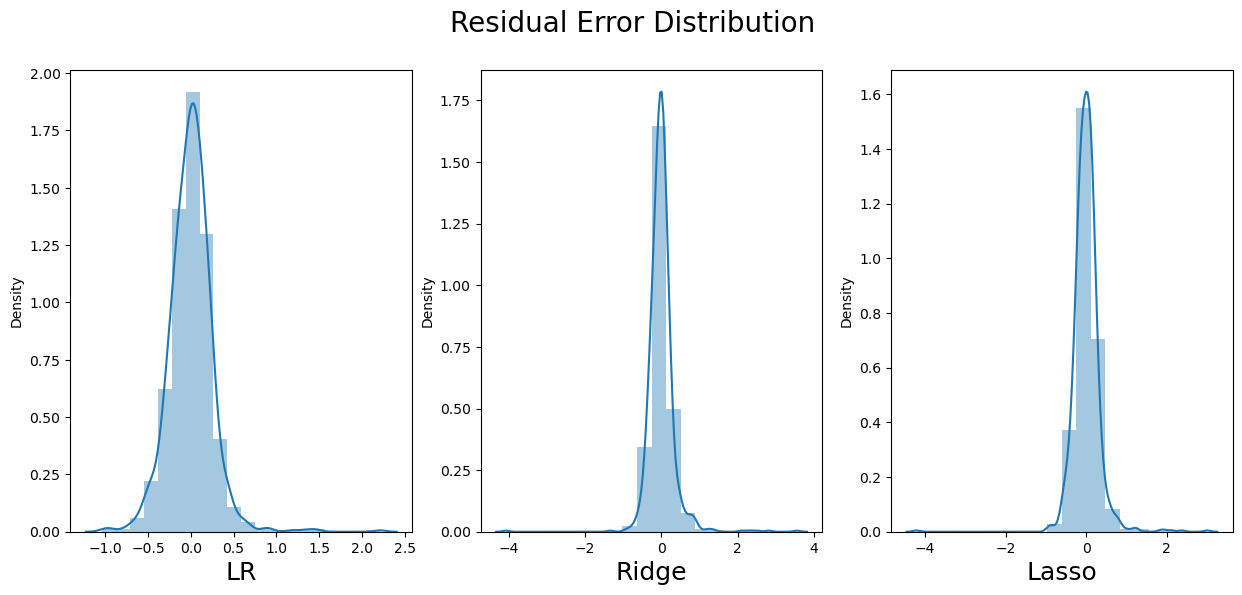

In [653]:
#Histogram plot for residual error (Y-actual - Y-predicted) - ON TRAINING DATA

fig = plt.figure(figsize=(15, 6))
fig.suptitle('Residual Error Distribution', fontsize = 20)   
plt.subplot(1,3,1)
sns.distplot(res_lr_train, bins = 20)
plt.xlabel('LR', fontsize = 18)   
plt.subplot(1,3,2)
sns.distplot(res_ridge_train, bins = 20)
plt.xlabel('Ridge', fontsize = 18)   
plt.subplot(1,3,3)
sns.distplot(res_lasso_train, bins = 20) 
plt.xlabel('Lasso', fontsize = 18)           
plt.show()

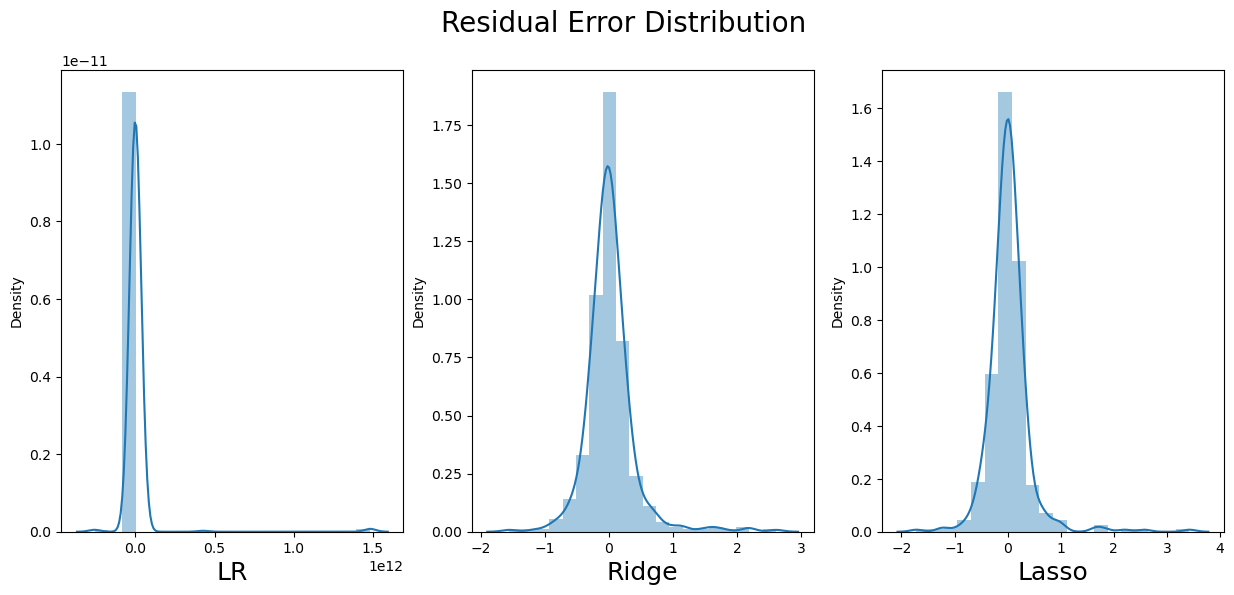

In [654]:
#Histogram plot for residual error (Y-actual - Y-predicted) - ON TEST DATA

fig = plt.figure(figsize=(15, 6))
fig.suptitle('Residual Error Distribution', fontsize = 20)   
plt.subplot(1,3,1)
sns.distplot(res_lr_test, bins = 20)
plt.xlabel('LR', fontsize = 18)   
plt.subplot(1,3,2)
sns.distplot(res_ridge_test, bins = 20)
plt.xlabel('Ridge', fontsize = 18)   
plt.subplot(1,3,3)
sns.distplot(res_lasso_test, bins = 20) 
plt.xlabel('Lasso', fontsize = 18)           
plt.show()

- Error terms follows normal distribution with zero mean

#### Model evaluation for test data

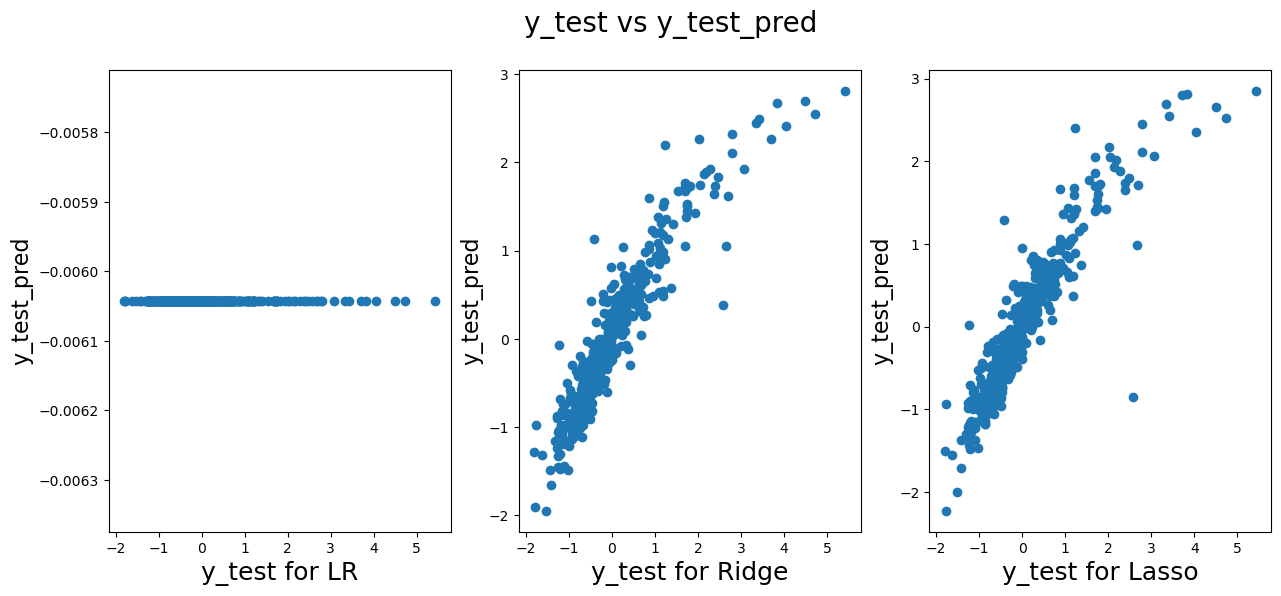

In [655]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure(figsize=(15, 6))
fig.suptitle('y_test vs y_test_pred', fontsize = 20)    
plt.subplot(1,3,1)
plt.scatter(y_test, y_pred_test)
plt.xlabel('y_test for LR', fontsize = 18)                        
plt.ylabel('y_test_pred', fontsize = 16)   
plt.subplot(1,3,2)
plt.scatter(y_test, y_pred_test2)
plt.xlabel('y_test for Ridge', fontsize = 18)                        
plt.ylabel('y_test_pred', fontsize = 16)  
plt.subplot(1,3,3)
plt.scatter(y_test, y_pred_test3)
plt.xlabel('y_test for Lasso', fontsize = 18)                        
plt.ylabel('y_test_pred', fontsize = 16)  
plt.show()

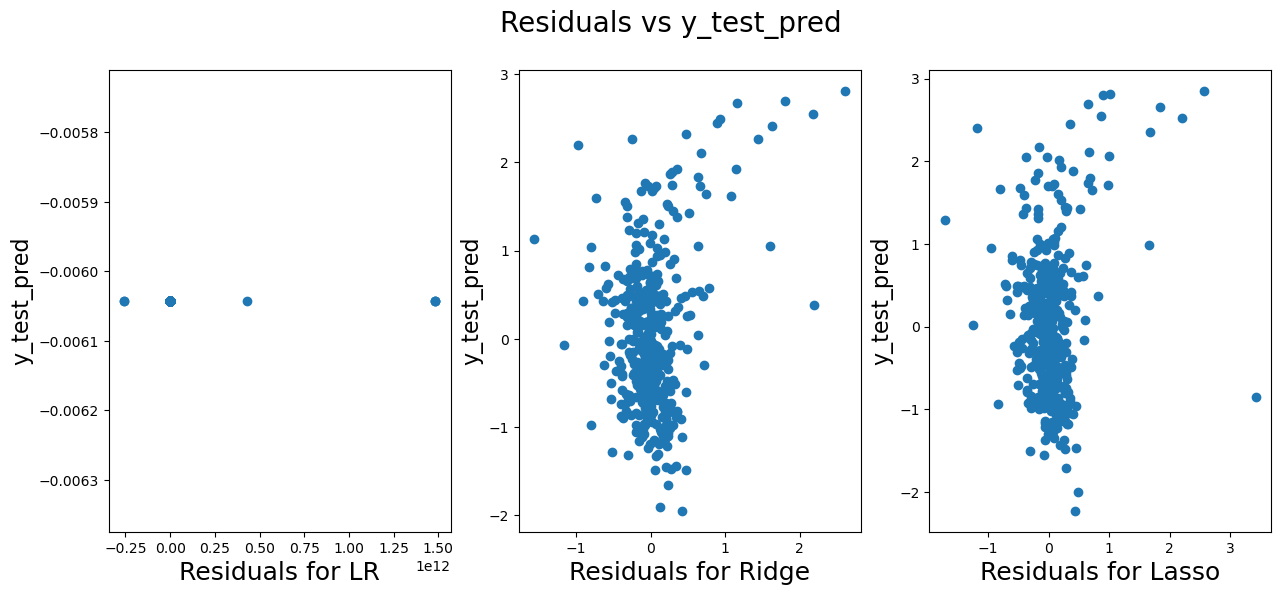

In [656]:
#Homoscedasticity check : Using scatter plot between residuals and predicted values
fig = plt.figure(figsize=(15, 6))
fig.suptitle('Residuals vs y_test_pred', fontsize = 20)     
plt.subplot(1,3,1)
plt.scatter(res_lr_test, y_pred_test)
plt.xlabel('Residuals for LR', fontsize = 18)                        
plt.ylabel('y_test_pred', fontsize = 16)   
plt.subplot(1,3,2)
plt.scatter(res_ridge_test, y_pred_test2)
plt.xlabel('Residuals for Ridge', fontsize = 18)                        
plt.ylabel('y_test_pred', fontsize = 16)   
plt.subplot(1,3,3)
plt.scatter(res_lasso_test, y_pred_test3)
plt.xlabel('Residuals for Lasso', fontsize = 18)                        
plt.ylabel('y_test_pred', fontsize = 16)   
plt.show()

There is no trend in distribution of residuals, which shows the models obey Homoscedasticity .

# Conclusion

Different models were built for predicting the prices of houses based on various features using:
- 1. Linear Regression
- 2. Ridge Regression
- 3. Lasso Regression

LR model had evident over fitting issues, which were addressed by building models with regularisation methods like Ridge and Lasso.

Ridge and Lasso models were built with different alpha (hyperparameter) values and the optimum value is identified. THis was used to build the final model of each reqularisation method
- Optimum alpha for Ridge: 500
- Optimum alpha for Lasso: 0.01

Model metrices like R2 values for train and test, mean square error are compared for the various models